# Forecasting Crypto Prices with the Transformer and Flow Forecast

[Flow Forecast is a open source deep learning for time series forecasting, classification, and anomaly detection framework built in PyTorch](https://github.com/AIStream-Peelout/flow-forecast). FF features state of the art time series forecasting models like the [Transformer]() which we will use to forecast the crypto target price. Please note here I'm purposefully not using the full dataset (actually only a very small fraction) in order to ensure the notebook execution completes before timing out.

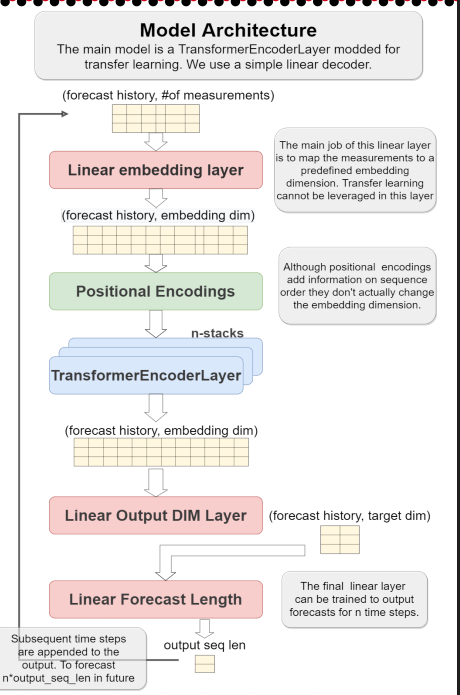

In [ ]:
from datetime import datetime
import os
!git clone https://github.com/AIStream-Peelout/flow-forecast.git -b add_minute_temporal
os.chdir("flow-forecast")
!python setup.py develop

In [ ]:
import pandas as pd
from datetime import datetime
train_df = pd.read_csv("../../input/g-research-crypto-forecasting/train.csv")
train_df["datetime"] = pd.to_datetime(train_df["timestamp"], unit='s')
train_df.to_csv("i.csv")

In [ ]:
# g = train_df.groupby('Asset_ID').cumcount()
# df = train_df.set_index(['timestamp', g]).unstack().sort_index(level=1, axis=1)
# This ran out of memory ^ 
single_train = train_df[train_df["Asset_ID"]==0]
single_train.to_csv("asset_0.csv")
single_train.dropna()
single_train

In [ ]:
single_train["Target"].describe()

## Defining the Configuration File

##### The first thing to do to start any FF experiment is to define a FF configuration file. Here since we want to use the transformer model we have to supply the proper parameters to initialize it. 
- model_params: In model parameters we will include the relevant arguments to instantiate a CustomTransformerDecoder model. 
    - n_time_series: The number of covariate + targets we are passing into the model in this case we have 13 (8 base features + 5 datetime featues)
    - seq_length: This
    - output_seq_length: The length the model forecasts in one forward pass. We will make this a tunable hyperparameter and gauge performance basesd on it. 
    - output_dim: This will be one in this instance because we are only forecasting one target variable. 
    - n_layers_encoder: The number of stacked transformer blocks. We will also make this a sweepable param. 
    
 dataset_params: Most of the dataset parameters should be pretty self-explanatory. 

    - train_start: The index to start training model on. Here I choose row 1000
    - train_end: The index to end training on. Here I choose row 10,000 in order ensure the notebook doesn't time out.
    - class: Here we use the default CSVDataLoader class. Other models like the Informer would require different datal
    - test_end: 
    
- inference_params: These are the parameters that we need for plotting the end charts

The second configuration file we define is the Weights and Biases sweep configuration file. This controls the hyperparameters we are sweeping over. Note in order to avoid Kaggle memory errors I have had to greatly limit the current sweep in this tutorial notebook. However, sweeps can parse over a huge range of values, sometimes I sweep over 200 different hyperparameter combos. Here we will do a basic sweep over batch_size learning rate, and forecast_history supplied to the forecasting model. 


In [ ]:
def make_config_file(csv_path, weight_path=None, pretrained=[]):
  run = wandb.init(project="bitcoin_forecasts")
  wandb_config = run.config
  the_wandb_c = run.config
  the_config4 =  {
    "model_name": "CustomTransformerDecoder",
    "use_decoder": True,
    "model_type": "PyTorch",
    "model_params": {
      "n_time_series":13,
      "seq_length":wandb_config["forecast_history"],
      "output_seq_length": wandb_config["forecast_length"], 
      "n_layers_encoder": wandb_config["n_layers_encoder"],
      "output_dim":1,
    },
      
    "dataset_params":
    {  "class": "default",
       "num_workers":4,
       "pin_memory": True,
       "training_path": csv_path,
       "validation_path": csv_path,
       "test_path": csv_path,
       "batch_size":wandb_config["batch_size"],
       "forecast_test_len":100,
       "forecast_history":wandb_config["forecast_history"],
       "forecast_length":wandb_config["forecast_length"],
       "no_scale": True,
       "scaler": "StandardScaler",
       "train_start":1000,
       "train_end": 10000,
       "valid_start":100000,
       "valid_end": 150100,
       "sort_column": "datetime",
       "test_start": 150100,
       "test_end":155300,
       "target_col": ["Target"],
       "relevant_cols": ["Target", "Count", "Open", "High", "Low", "Close", "Volume", "VWAP"], 
       "interpolate":{
           "method":"back_forward_generic",
           "params":{
               "relevant_columns":["Target", "Count", "Open", "High", "Low", "Close", "Volume", "VWAP"]
           }

       },
     "feature_param":
     {
         "datetime_params":{
            "month": "numerical",
            "day": "numerical",
            "day_of_week": "numerical",
            "hour":"numerical",
            "minute": "numerical"
         }
     }
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": wandb_config["optimizer"],
       #"criterion_params":{"baseline_method":"mean"},
    "optim_params":{
       "lr": the_wandb_c["lr"],
        "warmup": 0.1
    },
       "epochs": 10,
       "batch_size":wandb_config["batch_size"]
    },
    "early_stopping":{
        "patience":2
    },
    "GCS": False,
    "wandb":False,
    "sweep": True,
    "forward_params":{},
   "metrics":["MAPE", "MSE"],
   "inference_params":
   {     
         "datetime_start":"2020-05-31",
          "hours_to_forecast":336, 
          "num_prediction_samples": 20,
          "test_csv_path":csv_path,
          "decoder_params":{
            "decoder_function": "simple_decode", 
            "unsqueeze_dim": 1},
          "dataset_params":{
             "file_path": csv_path,
             "sort_column": "datetime",
             "scaling": "StandardScaler",
             "forecast_history": wandb_config["forecast_history"],
             "forecast_length": wandb_config["forecast_length"],
             "relevant_cols": ["Target", "Count", "Open", "High", "Low", "Close", "Volume", "VWAP"],
             "target_col": ["Target"],
             "interpolate_param":{
                 "method":"back_forward_generic",
                 "params":{"relevant_columns":["Target", "Count", "Open", "High", "Low", "Close", "Volume", "VWAP"]}
                 }, 
            "feature_params":
        {
         "datetime_params":{
            "month": "numerical",
            "day": "numerical",
            "day_of_week": "numerical",
            "hour":"numerical",
             "minute": "numerical"
         
     }
             }
          }
          } 
    }

      
  if weight_path:
    the_config4["weight_path"] = weight_path
  wandb.config.update(the_config4)
  print("config made")
  return the_config4
  
wandb_sweep_config_full = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "optimizer": {
            "values": ["BertAdam"]
        },
        "batch_size": {
            "values": [100, 400]
        },
        "lr":{
            "values":[0.001, 0.00005]
        },
        "forecast_history":{
            "values":[96]
        },
        "forecast_length":{
            "values": [2]
        },
        
       "n_layers_encoder": {
           "values": [2, 6]
       }
        
}}

Wandb sweeps

In [ ]:
import wandb
from flood_forecast.trainer import train_function
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("WANDB_KEY")
sweep_full = wandb.sweep(wandb_sweep_config_full, project="bitcoin_forecasts")
wandb.agent(sweep_full, lambda:train_function("PyTorch", make_config_file("asset_0.csv")))